<a href="https://colab.research.google.com/github/CoderAPS/ubc_ocean_2023/blob/main/ubc_ocean_2023_20231019_v1(EfficientNetv2L).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# In this exercise compare three pre-trained models (base models) for correctly
# predicting type of overian cancer out of 5 types from the dataset. Perorm first
# feature extraction and then fine tuning/transfer learning with these models.

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# change current directory to..
%cd /gdrive/MyDrive/DATA/ubc_ocean_2023_v1

/gdrive/MyDrive/DATA/ubc_ocean_2023_v1


In [ ]:
!ls

'train (1).zip'   train.csv   ubc_ocean_imgages_resized   ubc_ocean_img_rsz.zip


In [ ]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import sys
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Show versions of some the libraries
python_ver = !python --version

print(f'TF version: {tf.__version__}')
print(f'Python version: {python_ver[0]}')
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'Opencv (cv2) version: {cv2.__version__}')

TF version: 2.14.0
Python version: Python 3.10.12
Numpy version: 1.23.5
Pandas version: 1.5.3
Opencv (cv2) version: 4.8.0


In [ ]:
train = pd.read_csv('/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/train.csv')
train

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False
...,...,...,...,...,...
533,65022,LGSC,53355,46675,False
534,65094,MC,55042,45080,False
535,65300,HGSC,75860,27503,False
536,65371,HGSC,42551,41800,False


In [ ]:
img_paths = pd.DataFrame(glob.glob('/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_ocean_imgages_resized/*.png'),
                      columns=['png_path'])
img_paths['image_id'] = img_paths.png_path.map(lambda p: int(p.split('/')[-1].split('_')[0]))
img_paths

,png_path,image_id
0,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,4
1,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,66
2,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,281
3,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,91
4,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,1101
...,...,...
533,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,65533
534,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,64629
535,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,64950
536,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,65094


In [ ]:
train_data_set = train.merge(img_paths,on='image_id')
train_data_set

,image_id,label,image_width,image_height,is_tma,png_path
0,4,HGSC,23785,20008,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...
1,66,LGSC,48871,48195,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...
2,91,HGSC,3388,3388,True,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...
3,281,LGSC,42309,15545,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...
4,286,EC,37204,30020,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...
...,...,...,...,...,...,...
533,65022,LGSC,53355,46675,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...
534,65094,MC,55042,45080,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...
535,65300,HGSC,75860,27503,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...
536,65371,HGSC,42551,41800,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...


In [ ]:
# Number of labels
# Note, there is one more label 'Other' but no image train data set
train_data_set.label.unique()

array(['HGSC', 'LGSC', 'EC', 'CC', 'MC'], dtype=object)

In [ ]:
# Distribution of labels
train_data_set.label.value_counts(normalize=True)

HGSC    0.412639
EC      0.230483
CC      0.184015
LGSC    0.087361
MC      0.085502
Name: label, dtype: float64

In [ ]:
# Binarize target
lb = LabelBinarizer()
lb.fit(train_data_set.label.values)
print(f'Class labels: {lb.classes_}')
target_values = lb.transform(train_data_set.label.values)

binary_labels = pd.DataFrame(target_values,columns= lb.classes_,dtype=int)
train_data_set = pd.concat([train_data_set,binary_labels],axis=1)
train_data_set = train_data_set[['image_id',	'label','CC',	'EC',	'HGSC',	'LGSC',	'MC',
                     'is_tma','png_path','image_width',	'image_height']]

train_data_set

Class labels: ['CC' 'EC' 'HGSC' 'LGSC' 'MC']


,image_id,label,CC,EC,HGSC,LGSC,MC,is_tma,png_path,image_width,image_height
0,4,HGSC,0,0,1,0,0,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,23785,20008
1,66,LGSC,0,0,0,1,0,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,48871,48195
2,91,HGSC,0,0,1,0,0,True,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,3388,3388
3,281,LGSC,0,0,0,1,0,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,42309,15545
4,286,EC,0,1,0,0,0,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,37204,30020
...,...,...,...,...,...,...,...,...,...,...,...
533,65022,LGSC,0,0,0,1,0,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,53355,46675
534,65094,MC,0,0,0,0,1,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,55042,45080
535,65300,HGSC,0,0,1,0,0,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,75860,27503
536,65371,HGSC,0,0,1,0,0,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,42551,41800


In [ ]:
train_data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538 entries, 0 to 537
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      538 non-null    int64 
 1   label         538 non-null    object
 2   CC            538 non-null    int64 
 3   EC            538 non-null    int64 
 4   HGSC          538 non-null    int64 
 5   LGSC          538 non-null    int64 
 6   MC            538 non-null    int64 
 7   is_tma        538 non-null    bool  
 8   png_path      538 non-null    object
 9   image_width   538 non-null    int64 
 10  image_height  538 non-null    int64 
dtypes: bool(1), int64(8), object(2)
memory usage: 46.8+ KB


Image shape: (500, 500, 3)
Image data type: uint8
Min & Max values in image: 0 & 251
Image size: 0.750144 megabytes


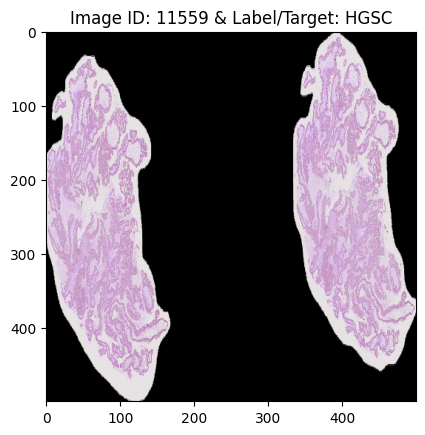

In [ ]:
# Random look at resized png images
img_path = img_paths.sample()['png_path'].values[0]
img_id = img_path.split('/')[-1].split('_')[0]
label = train_data_set.loc[train_data_set.image_id == int(img_id),'label'].values[0]
img = cv2.imread(img_path)
print(f'Image shape: {img.shape}')
print(f'Image data type: {img.dtype}')
print(f'Min & Max values in image: {img.min()} & {img.max()}')
print(f'Image size: {sys.getsizeof(img)/1000000} megabytes')
plt.imshow(img);
plt.title(f'Image ID: {img_id} & Label/Target: {label}');

In [ ]:
# configuration dataset and model
class CFG:
    competition   = 'UBC OCEAN 2023'
    comment       = 'Kaggle: ovarian carcinoma cancer classification'
    exp_name      = 'baseline_model_v1' # name of the experiment

    # use verbose=0 for silent, vebose=1 for interactive,
    verbose      = 1
    display_plot = True

    # device
    device = 'GPU' #"TPU-VM" #or "GPU"

    model_name = 'ResNet101'

    # seed for data-split, layer init, augs
    seed = 6

    # number of folds for data-split
    folds = 4

    # which folds to train
    selected_folds = [0, 1, 2]

    # size of the image
    img_size = [250, 250]

    # batch_size and epochs
    batch_size = 32
    epochs = [25,50] # model feature extraction and fine tunning

    # loss
    loss      = 'CCE'#'BCE & CCE' BCE, Focal

    # optimizer
    optimizer = 'Adam'

    # lr-scheduler
    scheduler   = 'None' #'cosine' # cosine

    augment = False

    # scale-shift-rotate-shear
    transform = 0.90  # transform prob
    fill_mode = 'constant'
    rot    = 2.0
    shr    = 2.0
    hzoom  = 50.0
    wzoom  = 50.0
    hshift = 10.0
    wshift = 10.0

    # flip
    hflip = True
    vflip = True

    # pixel-augment
    pixel_aug = 0.90  # prob of pixel_aug
    sat  = [0.7, 1.3]
    cont = [0.8, 1.2]
    bri  = 0.15
    hue  = 0.05


    # pre-fetch size
    prefetch_size = tf.data.AUTOTUNE

    # target column
    target_col  = ['CC', 'EC', 'HGSC', 'LGSC', 'MC']


In [ ]:
# split train dataset into training dataset(0,1,2) an validation dataset(3)
skf = StratifiedGroupKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_data_set,
                                                      train_data_set['label'],
                                                      train_data_set["image_id"])):
    train_data_set.loc[val_idx, 'fold'] = fold
display(train_data_set.groupby(['fold', 'image_id']).size())

fold  image_id
0.0   91          1
      281         1
      706         1
      1020        1
      1666        1
                 ..
3.0   63298       1
      63941       1
      64771       1
      65371       1
      65533       1
Length: 538, dtype: int64

In [ ]:
train_data_set

,image_id,label,CC,EC,HGSC,LGSC,MC,is_tma,png_path,image_width,image_height,fold
0,4,HGSC,0,0,1,0,0,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,23785,20008,2.0
1,66,LGSC,0,0,0,1,0,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,48871,48195,3.0
2,91,HGSC,0,0,1,0,0,True,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,3388,3388,0.0
3,281,LGSC,0,0,0,1,0,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,42309,15545,0.0
4,286,EC,0,1,0,0,0,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,37204,30020,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
533,65022,LGSC,0,0,0,1,0,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,53355,46675,1.0
534,65094,MC,0,0,0,0,1,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,55042,45080,1.0
535,65300,HGSC,0,0,1,0,0,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,75860,27503,2.0
536,65371,HGSC,0,0,1,0,0,False,/gdrive/MyDrive/DATA/ubc_ocean_2023_v1/ubc_oce...,42551,41800,3.0


In [ ]:
# Check label distribution of each fold (total of 4 folds)
train_data_set[train_data_set.fold != 3]['label'].value_counts(normalize=False)

HGSC    164
EC       92
CC       75
MC       38
LGSC     35
Name: label, dtype: int64

In [ ]:
len(train_data_set[train_data_set.fold != 3])

404

In [ ]:
#@title image augmentation: view original vs augmented - 1
def augment_img(img):
  img_aug = tf.image.random_flip_left_right(img)
  img_aug = tf.image.random_flip_up_down(img_aug)
  img_aug = tf.image.random_hue(img_aug, CFG.hue)
  img_aug = tf.image.random_saturation(img_aug, CFG.sat[0], CFG.sat[1])
  img_aug = tf.image.random_contrast(img_aug, CFG.cont[0], CFG.cont[1])
  img_aug = tf.image.random_brightness(img_aug, CFG.bri)

  #img_aug = tf.math.maximum(img_aug,0)
  #img_aug = img_aug.numpy()
  #np.where(img_aug == np.min(img_aug),0,img_aug)
  #print(f'img_aug type: {type(img_aug)}')
  '''
  aug_img =  tf.keras.layers.RandomRotation(0.2)(img)
  aug_img =  tf.keras.layers.RandomFlip('horizontal_and_vertical')(aug_img)
  aug_img = tf.image.random_brightness(aug_img,0.3)
  aug_img = aug_img / np.max(aug_img)
  aug_img = np.maximum(aug_img,0)
  aug_img = np.where(aug_img == np.min(aug_img),0, aug_img)
  '''
  return img_aug


In [ ]:
#@title image augmentation: view original vs augmented - 2
img_id = train_data_set.image_id.sample().values[0]
img_path = train_data_set.loc[train_data_set.image_id == img_id,'png_path'].values[0]
file_bytes = tf.io.read_file(img_path)
img = tf.image.decode_png(file_bytes, channels=3, dtype=tf.uint8)
#img = tf.image.resize(img, CFG.img_size, method='bilinear')

#img_rsc = tf.keras.layers.Rescaling(1./255, offset=0.0)(img)


#img = tf.cast(img, tf.float32) / tf.constant(255, dtype=tf.float32)

img_aug = augment_img(img)

print(f'Original img min: {np.min(img)} & max: {np.max(img)}')
#print(f'Rescaled img min: {np.min(img_rsc)} & max: {np.max(img_rsc)}')
print(f'Augmented img min: {np.min(img_aug)} & max: {np.max(img_aug)}')

plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f'Original')


plt.subplot(1,2,2)
plt.imshow(img_aug)
plt.title(f'Augmented')

#plt.subplot(1,3,3)
#plt.imshow(img_aug)
#plt.title(f'Augmented')

plt.tight_layout();


In [ ]:

def build_decoder(with_labels=True, target_size=CFG.img_size,ext='png'):
    def decode_image(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3, dtype=tf.uint8)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3, dtype=tf.uint8)
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.resize(img, target_size, method='bilinear')

        img = tf.cast(img, tf.float32) / 1. #255.0
        #img = tf.keras.layers.Rescaling(1./255, offset=0.0)(img)

        print(f'Decoding image: {img}')

        return img

    def decode_label(label):
        label = tf.cast(label, tf.float32)
        return label[0:5]

    def decode_with_labels(path, label):

        return decode_image(path), decode_label(label)

    return decode_with_labels if with_labels else decode



def build_augmenter(with_labels=True):

    def augment(img):
      img_aug = tf.image.random_flip_left_right(img)
      img_aug = tf.image.random_flip_up_down(img_aug)
      img_aug = tf.image.random_hue(img_aug, CFG.hue)
      img_aug = tf.image.random_saturation(img_aug, CFG.sat[0], CFG.sat[1])
      img_aug = tf.image.random_contrast(img_aug, CFG.cont[0], CFG.cont[1])
      img_aug = tf.image.random_brightness(img_aug, CFG.bri)
      #img_aug = tf.math.maximum(img_aug,0)


      #img =  tf.keras.layers.RandomRotation(0.2)(img)
      #img =  tf.keras.layers.RandomFlip('horizontal_and_vertical')(aug_img)
      #aug_img = tf.image.random_brightness(aug_img,0.3)
      #print(f'1. Augmented img type: {type(img)}')
      #aug_img = aug_img.numpy() / np.max(aug_img.numpy())
      #aug_img = np.maximum(aug_img,0)
      #aug_img = np.where(aug_img == np.min(aug_img),0, aug_img)
      #print(f'2. aug_img type: {type(aug_img)}')
      return img_aug

    def augment_with_labels(img, label):
      print(f'Augmenting image: {img}, label: {label}')
      return augment(img), label


    return augment_with_labels if with_labels else augment




In [ ]:
def build_dataset(paths, labels=None, batch_size=CFG.batch_size, cache=True,
                  decode_fn=None, augment_fn= None ,augment = CFG.augment,
                  shuffle=1024, repeat=True,
                  cache_dir="", drop_remainder=False):

    #if cache_dir != "" and cache is True:
    #    os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)


    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)

    ds = tf.data.Dataset.from_tensor_slices(slices)


    ds = ds.map(decode_fn, num_parallel_calls=AUTO)

    # Keeps the images in memory after they're loaded off disk during the first
    # epoch. This will ensure the dataset does not become a bottleneck while
    # training your model.
    #ds = ds.cache(cache_dir) if cache else ds

    #ds = ds.repeat() if repeat else ds


    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        #opt = tf.data.Options()
        #opt.experimental_deterministic = False
        #ds = ds.with_options(opt)

    ds = ds.map(augment_fn, num_parallel_calls=AUTO)  if augment else ds

    #ds = ds.batch(batch_size, drop_remainder=drop_remainder)

    # overlaps data preprocessing and model execution while training
    #ds = ds.prefetch(AUTO)

    return ds

In [ ]:

train_folds = CFG.selected_folds

# train and valid dataframe
train_df = train_data_set.query("fold in @train_folds")
valid_df = train_data_set.query("fold not in @train_folds")

# get image_paths and labels
train_paths = train_df.png_path.values#.reshape(-1,1)
train_labels = train_df[CFG.target_col].values.astype(float)
print(f'Number of samples in train_paths & train_labels: \
{len(train_paths)} & {len(train_labels)}')
print(f'Shape of train_paths: {train_paths.shape} & train_labels: {train_labels.shape}')

# Balance class distribution with RandomOverSampler
ros = RandomOverSampler(random_state=42)
train_paths_ros, train_labels_ros = ros.fit_resample(train_paths.reshape(-1,1),train_labels)
train_paths_ros = train_paths_ros.reshape(train_paths_ros.shape[0])

print(f'Number of samples in train_paths_ros & train_labels_ros: \
{len(train_paths_ros)} & {len(train_labels_ros)}')
print(f'Shape of train_paths: {train_paths_ros.shape} & train_labels: \
{train_labels_ros.shape}')


valid_paths = valid_df.png_path.values#.reshape(-1,1)
valid_labels = valid_df[CFG.target_col].values.astype(float)
print(f'Shape of valid_paths: {valid_paths.shape} & valid_labels: {valid_labels.shape}')

# shuffle train data
index = np.arange(len(train_df))
np.random.shuffle(index)
train_paths  = train_paths[index]
train_labels = train_labels[index]

fold = 0
# show message
print('#'*40); print('#### FOLD: ',fold)
print('#### IMAGE_SIZE: (%i, %i) | MODEL_NAME: %s | BATCH_SIZE: %i'%
          (CFG.img_size[0],CFG.img_size[1],CFG.model_name,CFG.batch_size))
# data stat
num_train = len(train_paths)
num_valid = len(valid_paths)

print('#### NUM_TRAIN: {:,} | NUM_VALID: {:,}'.format(num_train, num_valid))




Number of samples in train_paths & train_labels: 404 & 404
Shape of train_paths: (404,) & train_labels: (404, 5)
Number of samples in train_paths_ros & train_labels_ros: 820 & 820
Shape of train_paths: (820,) & train_labels: (820, 5)
Shape of valid_paths: (134,) & valid_labels: (134, 5)
########################################
#### FOLD:  0
#### IMAGE_SIZE: (250, 250) | MODEL_NAME: ResNet101 | BATCH_SIZE: 32
#### NUM_TRAIN: 404 | NUM_VALID: 134


In [ ]:
labels_df = pd.DataFrame(train_labels)
labels_df.value_counts(normalize=False)

0    1    2    3    4  
0.0  0.0  1.0  0.0  0.0    164
     1.0  0.0  0.0  0.0     92
1.0  0.0  0.0  0.0  0.0     75
0.0  0.0  0.0  0.0  1.0     38
               1.0  0.0     35
dtype: int64

In [ ]:
# build dataset
cache = 1 if 'GPU' in CFG.device else 1
train_ds = build_dataset(train_paths, train_labels,cache=cache, batch_size=CFG.batch_size,
                   repeat=True, shuffle=True,augment=CFG.augment)
val_ds = build_dataset(valid_paths, valid_labels, cache=cache, batch_size=CFG.batch_size,
                   repeat=False, shuffle=False,augment=False)

train_ds_ros = build_dataset(train_paths_ros, train_labels_ros,cache=cache,
                             batch_size=CFG.batch_size,repeat=True, shuffle=True,
                             augment=True)


Decoding image: Tensor("truediv:0", shape=(250, 250, 3), dtype=float32)
Decoding image: Tensor("truediv:0", shape=(250, 250, 3), dtype=float32)
Decoding image: Tensor("truediv:0", shape=(250, 250, 3), dtype=float32)
Augmenting image: Tensor("args_0:0", shape=(250, 250, 3), dtype=float32), label: Tensor("args_1:0", shape=(5,), dtype=float32)


In [ ]:
#CFG.batch_size
print(f'train_ds number of images: {train_ds.cardinality().numpy()}')
print(f'train_ds_ros number of images: {train_ds_ros.cardinality().numpy()}')
print(f'val_ds number of images: {val_ds.cardinality().numpy()}')



train_ds number of images: 404
train_ds_ros number of images: 820
val_ds number of images: 134


In [ ]:
train_ds

<_ShuffleDataset element_spec=(TensorSpec(shape=(250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5,), dtype=tf.float32, name=None))>

In [ ]:
# Show image from tensorflow dataset
def show_image_from_tf_dataset(dataset,batched=True,img_adj=1):
  plt.figure(figsize=(10, 10))
  for i in range(3):
    if batched:
      for img,label in dataset.shuffle(3).take(1):
        num = np.random.randint(len(img))
        plt.subplot(1, 3, i + 1)
        print(f'img min: {np.min(img[num])} & max: {np.max(img[num])}')
        print(f'img number unique values: {len(np.unique(img[num]))}')
        plt.imshow(img[num]/img_adj)
        #print(f'label: {type(label[0].numpy())}')
        plt.title(CFG.target_col[np.where(label[num].numpy() == 1)[0][0]])
        #plt.axis("off")
    else:
      for img,label in dataset.shuffle(17).take(1):
        plt.subplot(1, 3, i + 1)
        print(f'img min: {np.min(img)} & max: {np.max(img)}')
        print(f'img number unique values: {len(np.unique(img))}')
        plt.imshow(img/img_adj)
        #print(f'label: {type(label[0].numpy())}')
        plt.title(CFG.target_col[np.where(label.numpy() == 1)[0][0]])

img min: 0.0 & max: 252.25
img number unique values: 977
img min: 0.0 & max: 247.5
img number unique values: 965
img min: 0.0 & max: 241.25
img number unique values: 934


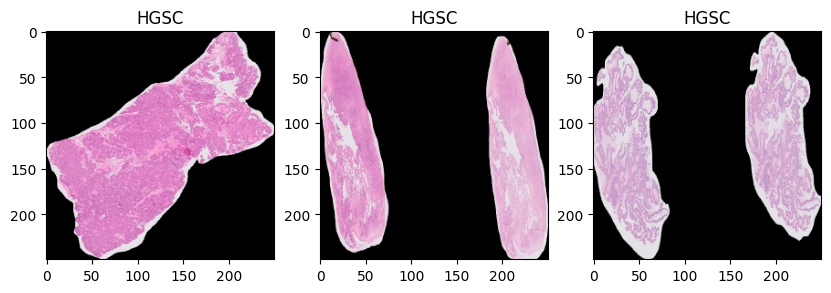

In [ ]:
show_image_from_tf_dataset(train_ds,False,255)

In [ ]:
# use this for feature extraction and transfer learning using base_model
def train_base_model(base_model,trainable=False,fine_tune_num=None):

  print(f'Number of layers in base model: {len(base_model.layers)}')

  # for feature extraction freeze the entire base_model
  if trainable == False:
    base_model.trainable = False
    print('Base_model layers are all frozed!')

  # for transfer learning train from 'fine_tune_num' layers of base_model
  # (and freeze the bottom layers)
  # along with classifier layer
  if trainable:
    # unfreeze base_model for training
    base_model.trainable = True

    # Fine-tune from this layer onwards
    fine_tune_at = fine_tune_num

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False

    #num = 0
    #for layer in base_model.layers:
    #  print(f'{num}: layer ==> {layer.trainable}')
    #  num += 1

    print(f'Base_model is trainable from layer {fine_tune_at}!')


In [ ]:
def build_model(base_model,drop_out,trainable=False,fine_tune_from=None,
                output_bias=None):

  if trainable:
    train_base_model(base_model,True,fine_tune_from)
  else:
    train_base_model(base_model)

  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  inputs = tf.keras.Input(shape=(*CFG.img_size,3))


  # add base_model
  base_model_layer = base_model(inputs,training=False)

  # average over the spatial 5x5 spatial locations, using a
  # GlobalAveragePooling2D layer
  pool_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_layer)

  batchnorm_layer = tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(pool_layer)

  dense_1a = tf.keras.layers.Dense(units=640, activation="elu")(batchnorm_layer)
  dropout_layer_1a = tf.keras.layers.Dropout(drop_out)(dense_1a)

  dense_1b = tf.keras.layers.Dense(units=320, activation="elu")(dropout_layer_1a)
  dropout_layer_1b = tf.keras.layers.Dropout(drop_out)(dense_1b)

  # Add a classification layer: don't need an activation function here because this prediction
  # will be treated as a logit, or a raw prediction value. Positive numbers predict class 1,
  # negative numbers predict class 0.
  outputs = tf.keras.layers.Dense(5, activation='softmax',
                                  bias_initializer=output_bias)(dropout_layer_1b)

  # Create model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)


  return model


In [ ]:
def evaluate_model(history,prev_history=None,fine_tunning=False,initial_epochs=0):
  if prev_history == None:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
  elif prev_history is not None:
    acc = prev_history.history['accuracy'] + history.history['accuracy']
    val_acc = prev_history.history['val_accuracy'] + history.history['val_accuracy']
    loss = prev_history.history['loss'] + history.history['loss']
    val_loss = prev_history.history['val_loss'] + history.history['val_loss']

  plt.figure(figsize=(12,4))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='upper left')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  if fine_tunning:
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),
             label='Start fine tunning')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Loss')
  #plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  if fine_tunning:
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),
             label='Start fine tunning')
  #plt.show()

  final_train_accuracy = history.history['accuracy'][-1]
  final_validation_accuracy = history.history['val_accuracy'][-1]

  final_train_loss = history.history['loss'][-1]
  final_validation_loss = history.history['val_loss'][-1]

  print(f'Training accuracy: {final_train_accuracy:.3f}\tTraining loss: {final_train_loss:.3f}')
  print(f'Validation accuracy: {final_validation_accuracy:.3f}\tValidation loss: {final_validation_loss:.3f}')


  accuracy_np = np.array(val_acc)
  max_val_accuracy = accuracy_np.max()
  max_val_accuracy_epoch = np.where(accuracy_np == max_val_accuracy)[0][0]

  loss_np = np.array(val_loss)
  min_val_loss = loss_np.min()
  min_val_loss_epoch = np.where(loss_np == min_val_loss)[0][0]


  print(f'Max val accuracy: {max_val_accuracy} at epoch: {max_val_accuracy_epoch}')
  print(f'Min val loss: {min_val_loss} at epoch: {min_val_loss_epoch}')

  return history

In [ ]:
# callbacks
def build_model_callbacks(store_at):
  callbacks = []
  checkpoint_path = store_at
  ## save best model
  sv = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path,
      monitor='val_accuracy',
      verbose=CFG.verbose,
      save_best_only=True,
      save_weights_only=False,
      mode='max',
      save_freq='epoch')

  callbacks +=[sv]

  early_stop = tf.keras.callbacks.EarlyStopping(
      monitor="val_accuracy",
      patience=10,
      start_from_epoch=0,
  )

  callbacks += [early_stop]

  return callbacks


In [ ]:
#===============================================================================================

In [ ]:
# Prediction with VGG19
efficientnetv2l = tf.keras.applications.EfficientNetV2L(
    include_top=False,
    weights="imagenet",
    input_shape= (*CFG.img_size,3),
    include_preprocessing=True
)

train_ds_p = train_ds.map(lambda x, y: (tf.keras.applications.efficientnet_v2.preprocess_input(x), y)).batch(CFG.batch_size).cache().prefetch(CFG.prefetch_size)
val_ds_p = val_ds.map(lambda x, y: (tf.keras.applications.efficientnet_v2.preprocess_input(x), y)).batch(CFG.batch_size).cache().prefetch(CFG.prefetch_size)

train_ds = train_ds.batch(CFG.batch_size).cache().prefetch(CFG.prefetch_size)
val_ds = val_ds.batch(CFG.batch_size).cache().prefetch(CFG.prefetch_size)




In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [ ]:
#efficientnetv2l.summary()

In [ ]:
print(f'Number of layers in base model: {len(efficientnetv2l.layers)}')

Number of layers in base model: 1028


img min: 40.5 & max: 247.75
img number unique values: 803
img min: 0.0 & max: 241.25
img number unique values: 920
img min: 0.0 & max: 237.75
img number unique values: 891


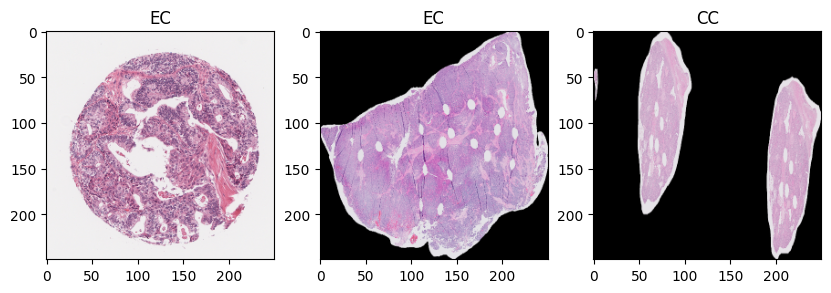

In [ ]:
# Show image from tensorflow dataset
show_image_from_tf_dataset(train_ds_p,True,255)

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [ ]:
model_efficientnetv2l = build_model(efficientnetv2l,0.5)

Number of layers in base model: 1028
Base_model layers are all frozed!


In [ ]:
model_efficientnetv2l.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model_efficientnetv2l.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 efficientnetv2-l (Function  (None, 8, 8, 1280)        117746848 
 al)                                                             
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_4 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 640)               819840    
                                                           

In [ ]:
# Check prediction of model before training
loss0,accuracy0 = model_efficientnetv2l.evaluate(val_ds)

5/5 [==============================] - 12s 376ms/step - loss: 1.8653 - accuracy: 0.1343


In [ ]:
print(f'Frozen base_model before classifier is trained')
print(f'Accuracy: {accuracy0:.3f}\t Loss: {loss0:.3f}')

Frozen base_model before classifier is trained
Accuracy: 0.134	 Loss: 1.865


In [ ]:
store_at = "/content/ubc_ocean_2023/ubc_ocean_2023_effientnetv2l_v1.ckpt"
callbacks = build_model_callbacks(store_at)
callbacks

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [ ]:
# train
print('Training...')
efficientnetv2l_history_fex = model_efficientnetv2l.fit(
        train_ds,
        epochs=CFG.epochs[0],
        callbacks = callbacks,
        validation_data=val_ds,
        verbose=CFG.verbose
    )

Training...
Epoch 1/25
13/13 [==============================] - ETA: 0s - loss: 3.2780 - accuracy: 0.2178
Epoch 1: val_accuracy improved from -inf to 0.18657, saving model to /content/ubc_ocean_2023/ubc_ocean_2023_effientnetv2l_v1.ckpt
13/13 [==============================] - 162s 11s/step - loss: 3.2780 - accuracy: 0.2178 - val_loss: 2.0945 - val_accuracy: 0.1866
Epoch 2/25
13/13 [==============================] - ETA: 0s - loss: 2.6047 - accuracy: 0.2748
Epoch 2: val_accuracy improved from 0.18657 to 0.29104, saving model to /content/ubc_ocean_2023/ubc_ocean_2023_effientnetv2l_v1.ckpt
13/13 [==============================] - 133s 11s/step - loss: 2.6047 - accuracy: 0.2748 - val_loss: 1.8458 - val_accuracy: 0.2910
Epoch 3/25
13/13 [==============================] - ETA: 0s - loss: 2.3020 - accuracy: 0.2995
Epoch 3: val_accuracy improved from 0.29104 to 0.32090, saving model to /content/ubc_ocean_2023/ubc_ocean_2023_effientnetv2l_v1.ckpt
13/13 [==============================] - 135s 11

Training accuracy: 0.738	Training loss: 0.694
Validation accuracy: 0.358	Validation loss: 2.139
Max val accuracy: 0.3955223858356476 at epoch: 14
Min val loss: 1.7677050828933716 at epoch: 3


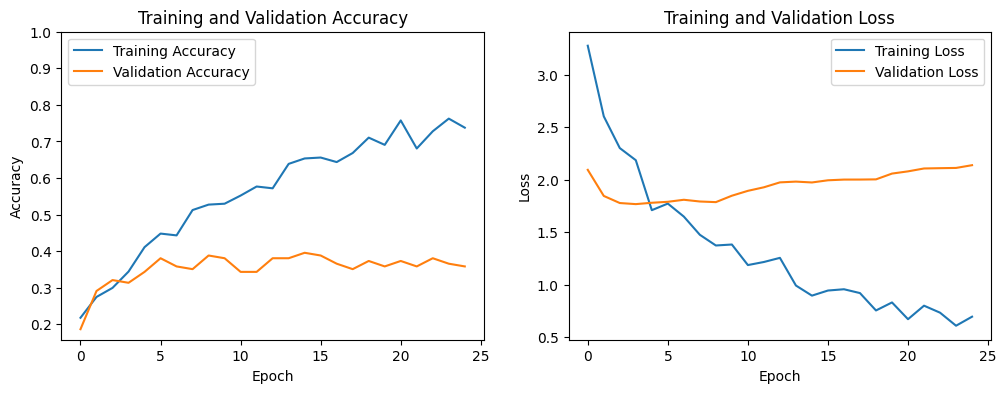

In [ ]:
evaluate_model(efficientnetv2l_history_fex)

In [ ]:
#block6:
#block7: 106
train_base_model(model_efficientnetv2l.layers[1],True,fine_tune_num=701)

Number of layers in base model: 1028
Base_model is trainable from layer 701!


In [ ]:
model_efficientnetv2l.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001/10),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
# train
print('Training - fine tunning')
efficientnetv2l_history_ftu = model_efficientnetv2l.fit(
        train_ds,
        epochs=CFG.epochs[1],
        callbacks = callbacks,
        validation_data=val_ds,
        verbose=CFG.verbose
    )

Training - fine tunning
Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.7228
Epoch 1: val_accuracy did not improve from 0.39552
13/13 [==============================] - 88s 2s/step - loss: 0.6982 - accuracy: 0.7228 - val_loss: 2.1465 - val_accuracy: 0.3731
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.5494 - accuracy: 0.7797
Epoch 2: val_accuracy did not improve from 0.39552
13/13 [==============================] - 13s 989ms/step - loss: 0.5494 - accuracy: 0.7797 - val_loss: 2.1506 - val_accuracy: 0.3582
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 0.4913 - accuracy: 0.8094
Epoch 3: val_accuracy did not improve from 0.39552
13/13 [==============================] - 13s 1s/step - loss: 0.4913 - accuracy: 0.8094 - val_loss: 2.1645 - val_accuracy: 0.3507
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.4472 - accuracy: 0.8119
Epoch 4: val_accuracy did not improve from 0.39552
13/13 

Training accuracy: 0.965	Training loss: 0.115
Validation accuracy: 0.351	Validation loss: 2.482
Max val accuracy: 0.3955223858356476 at epoch: 14
Min val loss: 1.7677050828933716 at epoch: 3


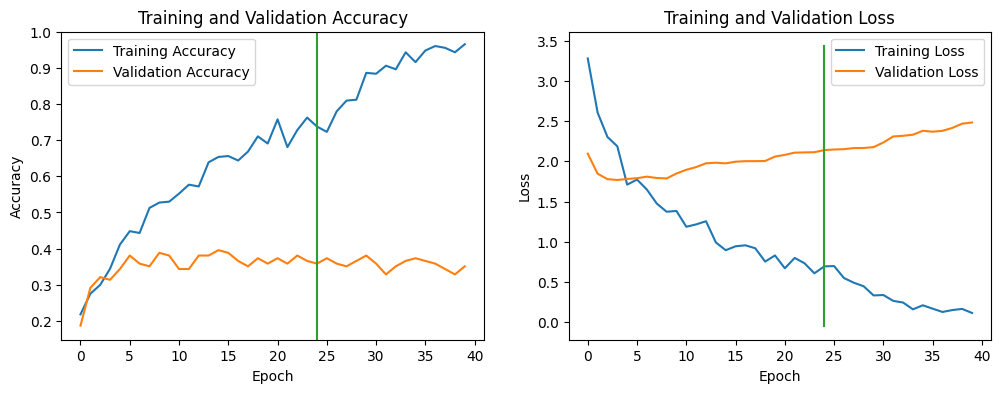

In [ ]:
evaluate_model(efficientnetv2l_history_ftu, efficientnetv2l_history_fex,True,
               len(efficientnetv2l_history_fex.history['loss']))

In [ ]:

######## Train model with random oversampling dataset: train_ds_ros #######################
# with image augmentation random flip horizontal and vertical

In [ ]:
train_ds_ros = train_ds_ros.batch(CFG.batch_size).cache().prefetch(CFG.prefetch_size)

train_ds_ros

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

img min: 17.797794342041016 & max: 237.00096130371094
img number unique values: 62773
img min: 28.624237060546875 & max: 233.11705017089844
img number unique values: 42470


img min: -33.499237060546875 & max: 274.39727783203125
img number unique values: 41871


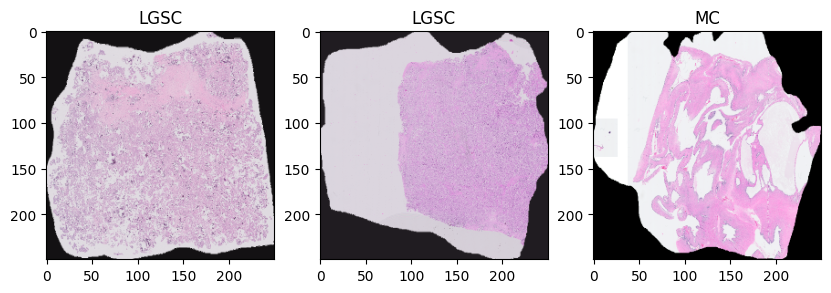

In [ ]:
# Show image from tensorflow dataset
show_image_from_tf_dataset(train_ds_ros,True,255)

In [ ]:
model_efficientnetv2l_ros = build_model(efficientnetv2l,0.5)

Number of layers in base model: 1028
Base_model layers are all frozed!


In [ ]:
model_efficientnetv2l_ros.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model_efficientnetv2l_ros.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 efficientnetv2-l (Function  (None, 8, 8, 1280)        117746848 
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 640)               819840    
                                                             

In [ ]:
# Check prediction of model before training
loss0,accuracy0 = model_efficientnetv2l_ros.evaluate(val_ds)

5/5 [==============================] - 22s 584ms/step - loss: 1.9100 - accuracy: 0.1716


In [ ]:
store_at = "/content/ubc_ocean_2023/ubc_ocean_2023_efficientnetv2l_ros_v1.ckpt"
callbacks = build_model_callbacks(store_at)
callbacks

In [ ]:
# train
print('Training...')
efficientnetv2l_ros_history_fex = model_efficientnetv2l_ros.fit(
        train_ds_ros,
        epochs=CFG.epochs[0],
        callbacks = callbacks,
        validation_data=val_ds,
        verbose=CFG.verbose)

Training...
Epoch 1/25
26/26 [==============================] - ETA: 0s - loss: 3.1730 - accuracy: 0.1829
Epoch 1: val_loss improved from inf to 1.74596, saving model to /content/ubc_ocean_2023/ubc_ocean_2023_efficientnetv2l_ros_v1.ckpt
26/26 [==============================] - 158s 5s/step - loss: 3.1730 - accuracy: 0.1829 - val_loss: 1.7460 - val_accuracy: 0.2985
Epoch 2/25
26/26 [==============================] - ETA: 0s - loss: 2.5445 - accuracy: 0.2488
Epoch 2: val_loss improved from 1.74596 to 1.70646, saving model to /content/ubc_ocean_2023/ubc_ocean_2023_efficientnetv2l_ros_v1.ckpt
26/26 [==============================] - 128s 5s/step - loss: 2.5445 - accuracy: 0.2488 - val_loss: 1.7065 - val_accuracy: 0.2836
Epoch 3/25
26/26 [==============================] - ETA: 0s - loss: 2.4362 - accuracy: 0.2805
Epoch 3: val_loss improved from 1.70646 to 1.69578, saving model to /content/ubc_ocean_2023/ubc_ocean_2023_efficientnetv2l_ros_v1.ckpt
26/26 [==============================] - 130s

Training accuracy: 0.529	Training loss: 1.348
Validation accuracy: 0.343	Validation loss: 1.774
Max val accuracy: 0.34328359365463257 at epoch: 7
Min val loss: 1.6592963933944702 at epoch: 5


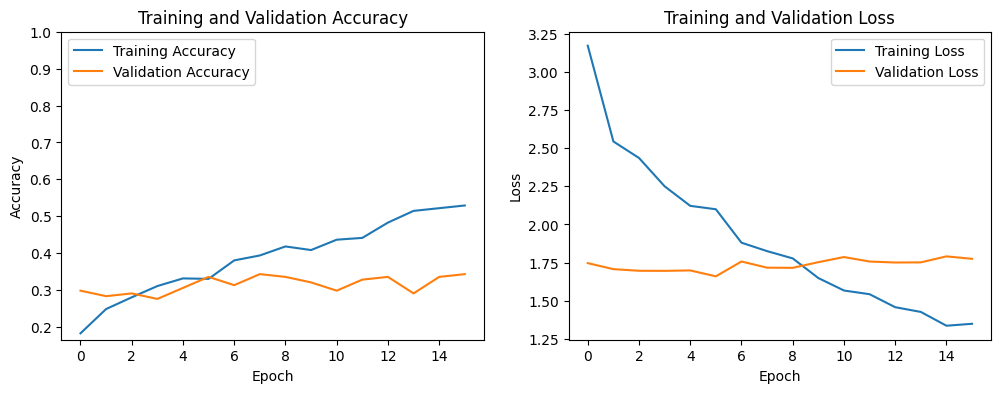

In [ ]:
evaluate_model(efficientnetv2l_ros_history_fex)

In [ ]:

train_base_model(model_efficientnetv2l_ros.layers[1],True,fine_tune_num=701)

Number of layers in base model: 1028
Base_model is trainable from layer 701!


In [ ]:
model_efficientnetv2l_ros.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001/10),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# train
print('Training - fine tunning')
efficientnetv2l_ros_history_ftu = model_efficientnetv2l_ros.fit(
        train_ds_ros,
        epochs=CFG.epochs[1],
        callbacks = callbacks,
        validation_data=val_ds,
        verbose=CFG.verbose)

Training - fine tunning
Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 1.2974 - accuracy: 0.5549
Epoch 1: val_loss did not improve from 1.65930
26/26 [==============================] - 99s 1s/step - loss: 1.2974 - accuracy: 0.5549 - val_loss: 1.7323 - val_accuracy: 0.3209
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 1.2395 - accuracy: 0.5610
Epoch 2: val_loss did not improve from 1.65930
26/26 [==============================] - 24s 907ms/step - loss: 1.2395 - accuracy: 0.5610 - val_loss: 1.7471 - val_accuracy: 0.3731
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 1.2281 - accuracy: 0.5549
Epoch 3: val_loss did not improve from 1.65930
26/26 [==============================] - 23s 896ms/step - loss: 1.2281 - accuracy: 0.5549 - val_loss: 1.7766 - val_accuracy: 0.3582
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 1.0503 - accuracy: 0.6146
Epoch 4: val_loss did not improve from 1.65930
26/26 [============

Training accuracy: 0.762	Training loss: 0.634
Validation accuracy: 0.366	Validation loss: 1.833
Max val accuracy: 0.3955223858356476 at epoch: 23
Min val loss: 1.6592963933944702 at epoch: 5


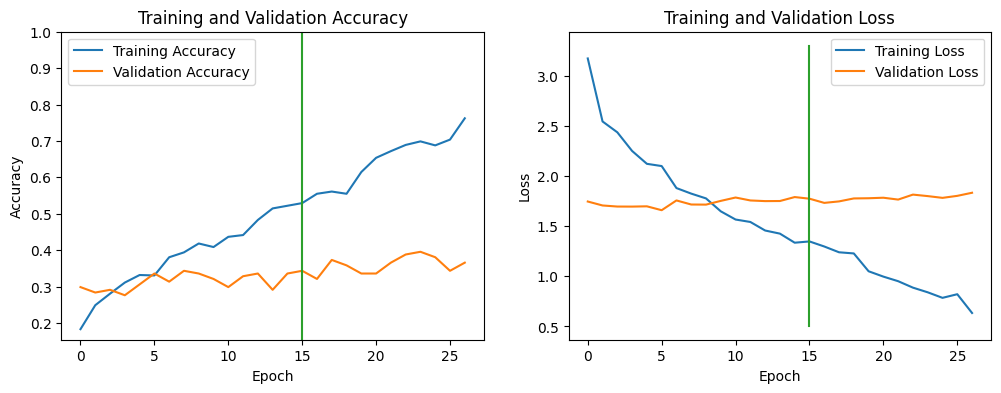

In [ ]:
evaluate_model(efficientnetv2l_ros_history_ftu, efficientnetv2l_ros_history_fex,
               True,len(efficientnetv2l_ros_history_fex.history['loss']))

In [ ]:
##### Use of
#  1. correct initial bias and
#  2. class_weights (balance imbalanced classification)
# for model training/prediction ###########################
# 1.Reference read: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
# 2. Reference read: https://deeplizard.com/learn/video/zralyi2Ft20


In [ ]:
initial_bias = []
class_counts = pd.DataFrame({'col': train_data_set.label.value_counts().index,
                             'counts': train_data_set.label.value_counts().values})
for idx, col in enumerate(CFG.target_col):
  num = class_counts.loc[class_counts['col'] == col,'counts'].values[0]
  initial_bias.append(np.log(num/(len(train_data_set) - num)))

print(initial_bias)
print(CFG.target_col)
print('\n')
train_data_set.label.value_counts().sort_index()

[-1.4893795629405815, -1.2055844082202776, -0.3530648317146327, -2.346296526084462, -2.3698373200032132]
['CC', 'EC', 'HGSC', 'LGSC', 'MC']




CC       99
EC      124
HGSC    222
LGSC     47
MC       46
Name: label, dtype: int64

In [ ]:

model_efficientnetv2l_wts = build_model(efficientnetv2l,drop_out=0.5,output_bias=initial_bias)


Number of layers in base model: 1028
Base_model layers are all frozed!


In [ ]:
model_efficientnetv2l_wts.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Check prediction of model before training
loss0,accuracy0 = model_efficientnetv2l_wts.evaluate(val_ds_p)

5/5 [==============================] - 14s 368ms/step - loss: 1.4320 - accuracy: 0.4328


In [ ]:
# check initial bias weights for last/top layer of model
wts_initial = model_efficientnetv2l_wts.get_weights()
wts_initial[-1]

array([-1.4893795 , -1.2055844 , -0.35306484, -2.3462965 , -2.3698373 ],
      dtype=float32)

In [ ]:
store_at = "/content/ubc_ocean_2023/ubc_ocean_2023_efficientnetv2l_wts_v1.ckpt"
callbacks = build_model_callbacks(store_at)
callbacks

In [ ]:
print(f'{CFG.target_col}')
class_counts = train_data_set.label.value_counts().sort_index().values
class_counts

['CC', 'EC', 'HGSC', 'LGSC', 'MC']


array([ 99, 124, 222,  47,  46])

In [ ]:
# Assign class weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
class_weights = {}
for idx,cnts in enumerate(class_counts):
  class_weights[idx] = (1/cnts)*(len(train_data_set)/2)

class_weights


{0: 2.7171717171717176,
 1: 2.1693548387096775,
 2: 1.2117117117117118,
 3: 5.723404255319148,
 4: 5.8478260869565215}

In [ ]:
# train
print('Training...')
efficientnetv2l_wts_history_fex = model_efficientnetv2l_wts.fit(
        train_ds,
        epochs=CFG.epochs[0],
        callbacks = callbacks,
        validation_data=val_ds,
        class_weight=class_weights,
        verbose=CFG.verbose)

Training...
Epoch 1/25
13/13 [==============================] - ETA: 0s - loss: 8.2027 - accuracy: 0.2550
Epoch 1: val_loss improved from inf to 1.79460, saving model to /content/ubc_ocean_2023/ubc_ocean_2023_efficientnetv2l_wts_v1.ckpt
13/13 [==============================] - 153s 11s/step - loss: 8.2027 - accuracy: 0.2550 - val_loss: 1.7946 - val_accuracy: 0.4104
Epoch 2/25
13/13 [==============================] - ETA: 0s - loss: 6.2086 - accuracy: 0.3317
Epoch 2: val_loss improved from 1.79460 to 1.72414, saving model to /content/ubc_ocean_2023/ubc_ocean_2023_efficientnetv2l_wts_v1.ckpt
13/13 [==============================] - 130s 11s/step - loss: 6.2086 - accuracy: 0.3317 - val_loss: 1.7241 - val_accuracy: 0.3806
Epoch 3/25
13/13 [==============================] - ETA: 0s - loss: 5.2423 - accuracy: 0.3985
Epoch 3: val_loss did not improve from 1.72414
13/13 [==============================] - 8s 621ms/step - loss: 5.2423 - accuracy: 0.3985 - val_loss: 1.7315 - val_accuracy: 0.3433


Training accuracy: 0.646	Training loss: 2.248
Validation accuracy: 0.373	Validation loss: 1.953
Max val accuracy: 0.41044774651527405 at epoch: 0
Min val loss: 1.724135398864746 at epoch: 1


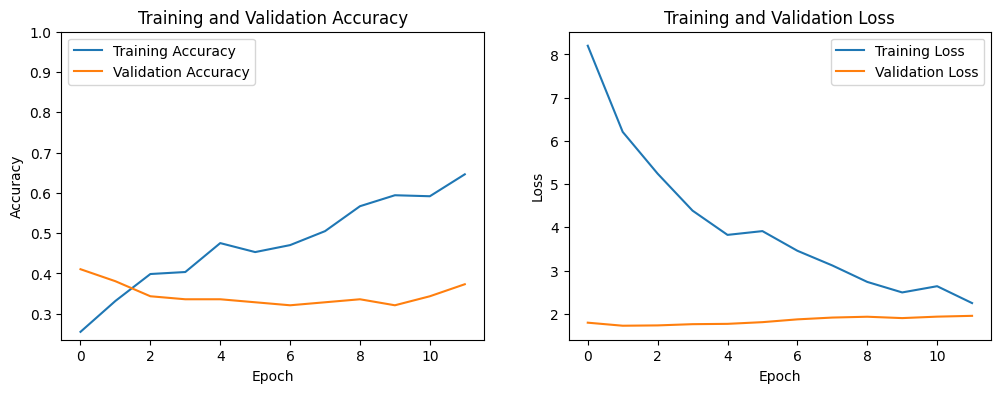

In [ ]:
evaluate_model(efficientnetv2l_wts_history_fex)

In [ ]:

train_base_model(model_efficientnetv2l_wts.layers[1],True,fine_tune_num=701)

Number of layers in base model: 1028
Base_model is trainable from layer 701!


In [ ]:
model_efficientnetv2l_wts.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001/10),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# train
print('Training - fine tunning')
efficientnetv2l_wts_history_ftu = model_efficientnetv2l_wts.fit(
        train_ds,
        epochs=CFG.epochs[1],
        callbacks = callbacks,
        validation_data=val_ds,
        class_weight=class_weights,
        verbose=CFG.verbose)

Training - fine tunning
Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 2.1058 - accuracy: 0.6287
Epoch 1: val_loss did not improve from 1.72414
13/13 [==============================] - 79s 2s/step - loss: 2.1058 - accuracy: 0.6287 - val_loss: 1.9851 - val_accuracy: 0.3358
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.9534 - accuracy: 0.6782
Epoch 2: val_loss did not improve from 1.72414
13/13 [==============================] - 13s 981ms/step - loss: 1.9534 - accuracy: 0.6782 - val_loss: 1.9479 - val_accuracy: 0.3657
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.7564 - accuracy: 0.7079
Epoch 3: val_loss did not improve from 1.72414
13/13 [==============================] - 13s 998ms/step - loss: 1.7564 - accuracy: 0.7079 - val_loss: 1.9444 - val_accuracy: 0.3582
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 1.2761 - accuracy: 0.7475
Epoch 4: val_loss did not improve from 1.72414
13/13 [============

Training accuracy: 0.886	Training loss: 0.616
Validation accuracy: 0.373	Validation loss: 2.190
Max val accuracy: 0.41044774651527405 at epoch: 0
Min val loss: 1.724135398864746 at epoch: 1


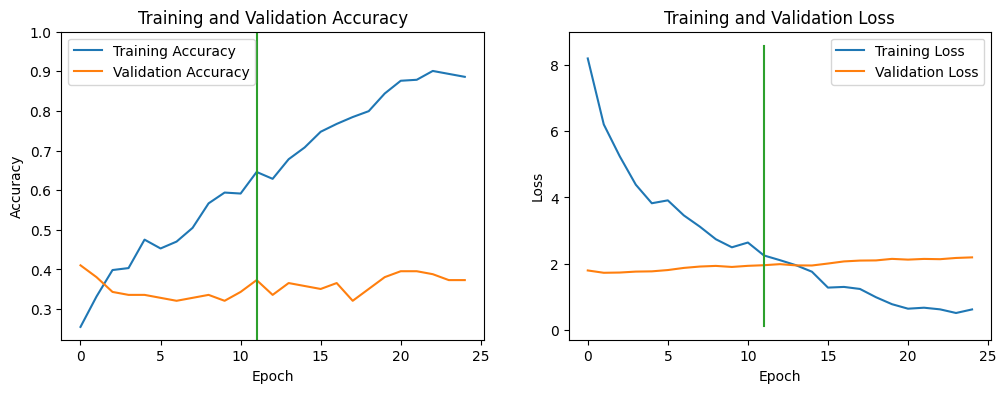

In [ ]:
evaluate_model(efficientnetv2l_wts_history_ftu, efficientnetv2l_wts_history_fex,
               True,len(efficientnetv2l_wts_history_fex.history['loss']))

In [ ]:
#===========================================================================================
# Train with random oversampled train data set and weights

In [ ]:
model_resnet101_ros_wts = build_model(resnet101,drop_out=0.5,output_bias=initial_bias)

Number of layers in base model: 345
Base_model layers are all frozed!


In [ ]:
model_resnet101_ros_wts.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Check prediction of model before training
loss0,accuracy0 = model_resnet101_ros_wts.evaluate(val_ds_p)

5/5 [==============================] - 4s 151ms/step - loss: 1.8876 - accuracy: 0.2761


In [ ]:
store_at = "/content/ubc_ocean_2023/ubc_ocean_2023_resnet101_ros_wts_v1.ckpt"
callbacks = build_model_callbacks(store_at)
callbacks

In [ ]:
# train
print('Training...')
resnet101_ros_wts_history_fex = model_resnet101_ros_wts.fit(
        train_ds_ros_p,
        epochs=CFG.epochs[0],
        callbacks = callbacks,
        validation_data=val_ds_p,
        class_weight=class_weights,
        verbose=CFG.verbose)

Training...
Epoch 1/25
26/26 [==============================] - ETA: 0s - loss: 13.2940 - accuracy: 0.2073
Epoch 1: val_loss improved from inf to 2.18187, saving model to /content/ubc_ocean_2023/ubc_ocean_2023_resnet101_ros_wts_v1.ckpt
26/26 [==============================] - 45s 1s/step - loss: 13.2940 - accuracy: 0.2073 - val_loss: 2.1819 - val_accuracy: 0.2910
Epoch 2/25
26/26 [==============================] - ETA: 0s - loss: 10.7934 - accuracy: 0.2427
Epoch 2: val_loss did not improve from 2.18187
26/26 [==============================] - 6s 216ms/step - loss: 10.7934 - accuracy: 0.2427 - val_loss: 2.2617 - val_accuracy: 0.2687
Epoch 3/25
26/26 [==============================] - ETA: 0s - loss: 8.9543 - accuracy: 0.2963
Epoch 3: val_loss did not improve from 2.18187
26/26 [==============================] - 6s 219ms/step - loss: 8.9543 - accuracy: 0.2963 - val_loss: 2.3096 - val_accuracy: 0.2612
Epoch 4/25
26/26 [==============================] - ETA: 0s - loss: 8.5423 - accuracy: 0

Training accuracy: 0.445	Training loss: 5.523
Validation accuracy: 0.172	Validation loss: 2.727
Max val accuracy: 0.29104477167129517 at epoch: 0
Min val loss: 2.1818675994873047 at epoch: 0


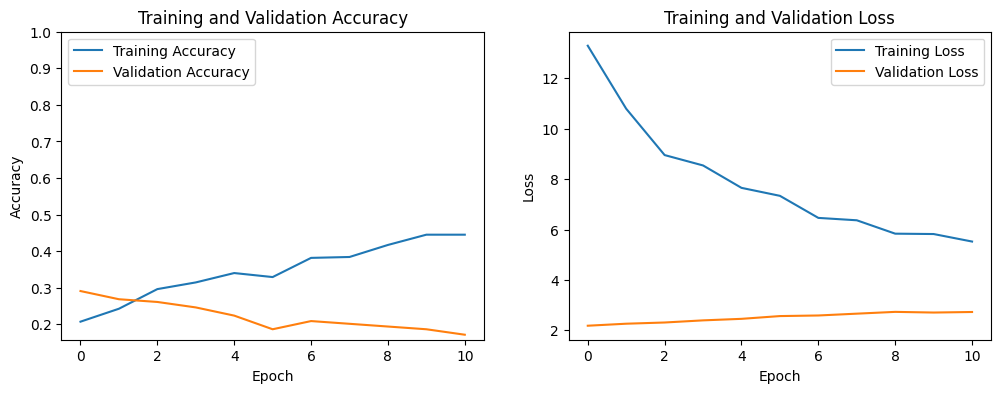

In [ ]:
evaluate_model(resnet101_ros_wts_history_fex)

In [ ]:
# This will show you the current GPU memory usage. You can then use the
# following command to increase the GPU memory:
!nvidia-smi -l 1

Sat Nov 18 19:02:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    39W / 300W |  15532MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#This will increase the GPU memory for device 0 to 2048MB.
!nvidia-smi -g 0 -l 1 -c 2048

In [ ]:
image = tf.constant(np.arange(1, 13, dtype=np.int32), shape=[2, 2, 3])
image # 3-D tensor












<tf.Tensor: shape=(2, 2, 3), dtype=int32, numpy=
array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]]], dtype=int32)>

In [ ]:
new_image = tf.image.per_image_standardization(image)
new_image # 3-D tensor with mean ~= 0 and variance ~= 1

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[-1.593255  , -1.3035723 , -1.0138896 ],
        [-0.7242068 , -0.4345241 , -0.14484136]],

       [[ 0.14484136,  0.4345241 ,  0.7242068 ],
        [ 1.0138896 ,  1.3035723 ,  1.593255  ]]], dtype=float32)>